In [1]:
# import modules

import numpy as np
import datetime
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import pandas as pd

import gc

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# Constants definition:
CS_Rejected = 1
CS_Entered  = 2
CS_Checked  = 4
CS_Valuated = 16

RS_Idle = 1
RS_NotSelected = 2
RS_SelectedForReview = 4
RS_Reviewed = 8
RS_Bypassed = 16

#RR:RejectionReason
RR_Accepted = 0 
RR_RbyMO    = -1

#CIS:ClaimItemStatus
CIS_Accepted = 1
CIS_Rejected = 2

/home/simona/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Introduction
**Note**: the data preparation step covers several tasks related to
- Data concatenation
- Sanity check: verify if all the data is coherent and exclude incoherencies;
- **Filling missing values** in the dataset: filling strategies specific to each column
- **Converting categorical** data to numeric: date and text variables
- **Data normalization**

# Filling missing values

The present file is dealing with filling the missing values in the cleaned dataset.

In [2]:
df_cleandata_labeled = pd.read_pickle('openIMIS csv/AllData_LabeledData_Selection.pkl') 

In [3]:
df_cleandata_labeled['HFSublevel'].isnull().sum()

240788

In [4]:
print(f''' All the columns presenting missing values are: 

{list(df_cleandata_labeled.columns[df_cleandata_labeled.isnull().any()])}.

As part of the columns will be dropped as no longer necessary, we will continue filling of \
missing values only for necessary columns, i.e \
'QtyApproved', 'PriceApproved', 'ICDID1', 'Relationship'.

Concerning the other columns:
- 'Explanation', 'Justification', 'Adjustment', 'ClaimExplanation' - are text fields,\
necessary for the communication between patient, ClaimAdmin, Medical Officer and \
it is important in order to understand this communication and extract rejection reasons; \
It will no longer be necessary, can be droped;
- ClaimCategory: as 2 318 982 values are missing, this field will be droped;
- Marital: as 1 609 393 values are missing, this fields will be droped;
- HFSublevel: as 240 788 values are missing and there is no strategy \
for filling the missing values, this column will be droped;
''')


 All the columns presenting missing values are: 

['QtyApproved', 'PriceApproved', 'PriceValuated', 'Explanation', 'Justification', 'Adjustment', 'Approved', 'DateProcessed', 'ClaimExplanation', 'ICDID1', 'ClaimCategory', 'Marital', 'Relationship', 'HFSublevel'].

As part of the columns will be dropped as no longer necessary, we will continue filling of missing values only for necessary columns, i.e 'QtyApproved', 'PriceApproved', 'ICDID1', 'Relationship'.

Concerning the other columns:
- 'Explanation', 'Justification', 'Adjustment', 'ClaimExplanation' - are text fields,necessary for the communication between patient, ClaimAdmin, Medical Officer and it is important in order to understand this communication and extract rejection reasons; It will no longer be necessary, can be droped;
- ClaimCategory: as 2 318 982 values are missing, this field will be droped;
- Marital: as 1 609 393 values are missing, this fields will be droped;
- HFSublevel: as 240 788 values are missing and there is 

In [5]:
droped_cols = ['ClaimCategory','Marital','HFSublevel',\
              'Explanation', 'Justification', 'Adjustment', 'ClaimExplanation',\
              'DateProcessed']
df_cleandata_labeled.drop(droped_cols, axis=1, inplace=True)               


## Step 1.1:  Fill missing values in the QtyApproved column

In [6]:
# if rejected item, QtyApproved = 0:
index_qty = (df_cleandata_labeled['Class']=='Rejected')&(df_cleandata_labeled['QtyApproved']>0)
df_cleandata_labeled.loc[index_qty,'PriceValuated'].value_counts().sort_index()

Series([], Name: PriceValuated, dtype: int64)

In [7]:
# Check if negative quantities values:
index = df_cleandata_labeled['QtyProvided']<0
if index.sum()>0:
    df_cleandata_labeled.loc[index,'QtyProvided']=df_cleandata_labeled.loc[index,'QtyProvided'].abs()

# if rejected item, QtyApproved = 0:
index_qty = df_cleandata_labeled['Class']=='Rejected'
df_cleandata_labeled.loc[index_qty,'QtyApproved'] = 0

# if accepted item and null value for QtyApprovec: QtyApproved = QtyProvided
index_qty = (df_cleandata_labeled['Class']=='Accepted')&\
(df_cleandata_labeled['QtyApproved'].isnull())
df_cleandata_labeled.loc[index_qty,'QtyApproved'] = df_cleandata_labeled.loc[index_qty,'QtyProvided']
df_cleandata_labeled['QtyApproved'].isnull().sum()

0

<Figure size 864x576 with 0 Axes>

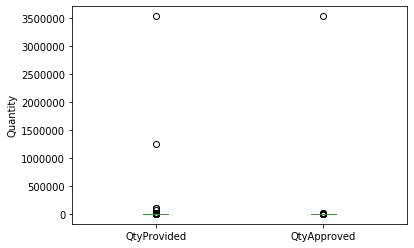

In [8]:
# visualisation of results in terms of QtyProvided and QtyApproved
figs = plt.figure(figsize=(12,8))
df = df_cleandata_labeled[['QtyProvided','QtyApproved']]

df.plot(kind='box')
plt.ylabel("Quantity")

plt.show()

## Step 1.2: Fill missing values in the PriceApproved column

In [9]:
index_price = (df_cleandata_labeled['Class']=='Rejected')
df_cleandata_labeled.loc[index_price,'PriceApproved'] = 0

index_price = (df_cleandata_labeled['Class']=='Accepted')&(df_cleandata_labeled['PriceApproved'].isnull())

df_cleandata_labeled.loc[index_price,'PriceApproved'] = df_cleandata_labeled.loc[index_price,'PriceAsked']

<Figure size 864x576 with 0 Axes>

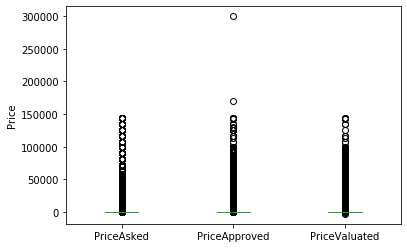

In [10]:
figs = plt.figure(figsize=(12,8))
df = df_cleandata_labeled[['PriceAsked','PriceApproved','PriceValuated']]
index = df_cleandata_labeled['Class'] == 'Rejected'

df.plot(kind='box')
plt.ylabel("Price")

plt.show()

## Step 1.3: Filling missing values in ICDID1 field

In [11]:
# if missing value in ICDID1, we will copy the values in ICDID:
index = df_cleandata_labeled['ICDID1'].isnull()
df_cleandata_labeled.loc[index,'ICDID1'] = df_cleandata_labeled.loc[index,'ICDID']

## Step 1.4: Filling missing values in Relationship field

In [12]:
index1 = (df_cleandata_labeled['Relationship'].isnull())&\
(df_cleandata_labeled['IsHead'] == 1)

index2 = (df_cleandata_labeled['Relationship'].isnull())&\
(df_cleandata_labeled['IsHead'] == 0)

print(f''' The 'Relationship' column contains \
{df_cleandata_labeled['Relationship'].isnull().sum()} missing values, where:
- {index1.sum()} corresponds to the head of family;
- {index2.sum()} corresponds to unknown values;
''')

 The 'Relationship' column contains 2419951 missing values, where:
- 2372944 corresponds to the head of family;
- 47007 corresponds to unknown values;



In [13]:
# Fill missing values in Relationship:
# if FamilyHead, we will insert 9 for the missing values
df_cleandata_labeled.loc[index1,'Relationship'] = 9 
# else, fill 10 (equivalent to 'not known')
df_cleandata_labeled.loc[index2,'Relationship'] = 10 

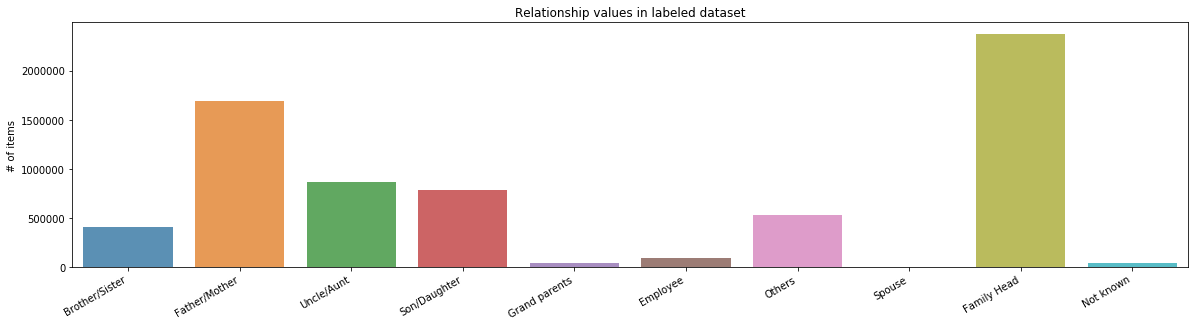

In [14]:
# Visualisation: illustrate the number of items per relationship value

figs = plt.figure(figsize=(20,5))

items_count  = df_cleandata_labeled['Relationship'].value_counts().sort_index()
sns.barplot(items_count.index, items_count.values, alpha=0.8)
plt.title("Relationship values in labeled dataset")
plt.xticks(range(10),['Brother/Sister', 'Father/Mother','Uncle/Aunt',\
                      'Son/Daughter','Grand parents','Employee',\
                     'Others','Spouse','Family Head','Not known'])
plt.ylabel("# of items")
plt.gcf().autofmt_xdate()

# Convert categorical variables to numeric

In this case, categorical variables can be represented by datetime variables or character/text variables. As the Ai model can consider only numeric variables, these variables must be convertes.
Several strategies can be applied:
- for datetime variables: convertion to variables representing years or days;
- for character/text variables, a dictionairy will be created associating distinct values in the dataset to numeric values; several methods are already implemented in python for this conversion step

## Step 1: Convert DOB (Date of Birth) field

In [15]:
# Calculating the Age of a patient
df_cleandata_labeled.loc[:,'Age'] = (df_cleandata_labeled['DateFrom'] - df_cleandata_labeled['DOB']).dt.total_seconds() / (60*60*24*365.25)

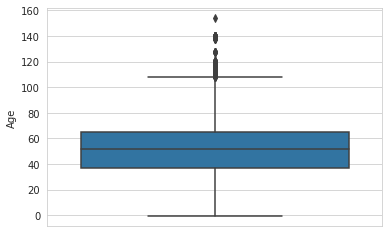

In [16]:
sns.set_style("whitegrid") 

sns.boxplot( y = 'Age', data = df_cleandata_labeled) 


In [17]:
# Drop DOB column as no longer necessary
df_cleandata_labeled.drop(['DOB'], axis=1, inplace=True)   

## Step 2: Convert datetime variables to numeric

In [18]:
date_cols = df_cleandata_labeled.select_dtypes(include=['datetime64']).columns
print(date_cols)

Index(['DateFrom', 'DateTo', 'DateClaimed', 'PhotoDate'], dtype='object')


In [19]:
# Convert to number of days the columns 
cols = ['DateFrom', 'DateTo', 'DateClaimed','PhotoDate']
for i in date_cols:
    df_cleandata_labeled[i]=(df_cleandata_labeled[i]-datetime.datetime(2016,1,1)).dt.days

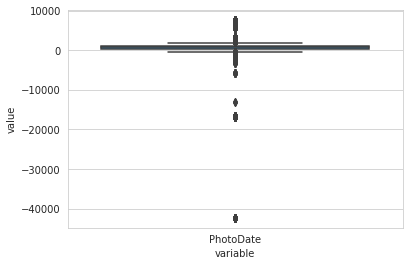

In [20]:
sns.set_style("whitegrid") 
sns.boxplot(x="variable", y="value", data=pd.melt(df_cleandata_labeled[['PhotoDate']]))

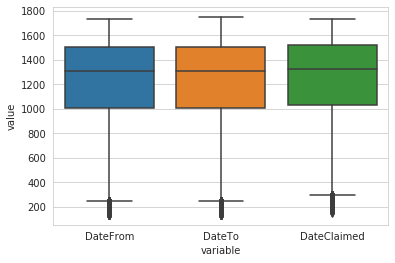

In [21]:
sns.set_style("whitegrid") 
sns.boxplot(x="variable", y="value",\
            data=pd.melt(df_cleandata_labeled[['DateFrom', 'DateTo', 'DateClaimed']]))

## Step 3: Convert text variables to numeric

In [22]:
obj_df = df_cleandata_labeled.select_dtypes(include=['object']).copy()
print(list(obj_df))

['ItemServiceType', 'ItemCode', 'ItemType', 'ItemCareType', 'ItemUUID', 'ItemLevel', 'ClaimCode', 'VisitType', 'ClaimUUID', 'ClaimAdminUUID', 'CHFID', 'Gender', 'TypeOfId', 'InsureeUUID', 'FamilyUUID', 'InsureeLocationType', 'LocationUUID', 'HFCode', 'HFLevel', 'HFCareType', 'HFUUID', 'LocationCode', 'HFLocationUUID', 'ICDCode', 'SanityCheck', 'Label', 'Class']


In [23]:
df_cleandata_labeled.shape

(6851424, 57)

In [24]:
for i in obj_df:
    le = LabelEncoder()
    df_cleandata_labeled[i]= le.fit_transform(df_cleandata_labeled[i])

# Data Normalization

In [25]:
all_cols = df_cleandata_labeled.columns
print(list(all_cols))

['ClaimItemStatus', 'QtyProvided', 'QtyApproved', 'PriceAsked', 'PriceApproved', 'PriceValuated', 'RejectionReason', 'ItemServiceType', 'ItemCode', 'ItemType', 'ItemPrice', 'ItemCareType', 'ItemFrequency', 'ItemPatCat', 'ItemUUID', 'ItemLevel', 'ClaimCode', 'DateFrom', 'DateTo', 'ICDID', 'ClaimStatus', 'Claimed', 'Approved', 'DateClaimed', 'ReviewStatus', 'ICDID1', 'VisitType', 'ClaimUUID', 'ClaimAdminUUID', 'CHFID', 'Gender', 'IsHead', 'PhotoDate', 'Relationship', 'TypeOfId', 'InsureeUUID', 'Poverty', 'FamilyUUID', 'InsureeLocationType', 'LocationUUID', 'HFCode', 'HFLevel', 'HFCareType', 'HFUUID', 'LocationCode', 'HFLocationUUID', 'ICDCode', 'ValidItem', 'ValidClaimAdmin', 'ValidInsuree', 'ValidFamily', 'ValidLocation', 'ValidICD', 'SanityCheck', 'Label', 'Class', 'Age']


In [26]:
df_cleandata_labeled[['ClaimItemStatus','ReviewStatus','RejectionReason','ClaimStatus']].value_counts().sort_index()

ClaimItemStatus  ReviewStatus  RejectionReason  ClaimStatus
1.0              8.0            0.0             4.0             213227
                                                16.0           6379122
2.0              8.0           -1.0             1.0              59908
                                                4.0               4799
                                                16.0            194368
dtype: int64

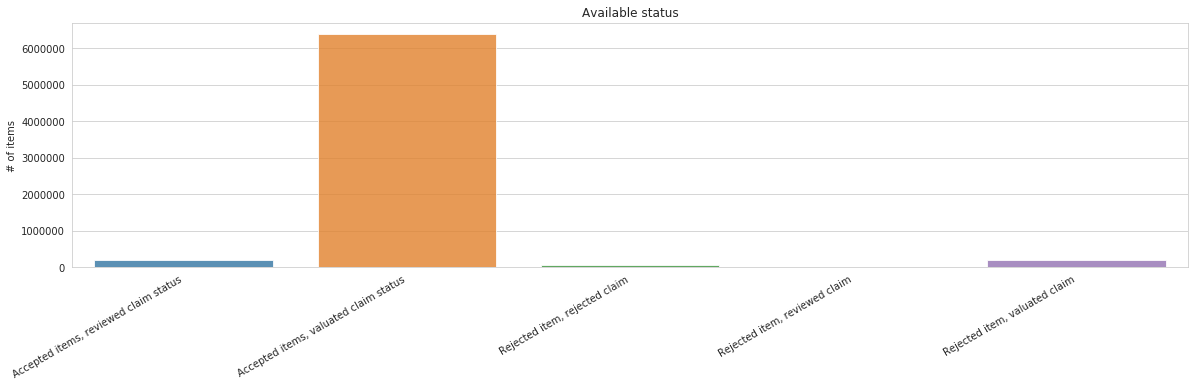

In [27]:
# Visualisation: illustrate the number of items per relationship value

figs = plt.figure(figsize=(20,5))

items_count  = df_cleandata_labeled[['ClaimItemStatus','ReviewStatus','RejectionReason','ClaimStatus']].value_counts().sort_index()
sns.barplot(items_count.index, items_count.values, alpha=0.8)
plt.xticks(range(5),['Accepted items, reviewed claim status', 'Accepted items, valuated claim status',\
                     'Rejected item, rejected claim','Rejected item, reviewed claim',\
                     'Rejected item, valuated claim',])
plt.title("Available status")
plt.ylabel("# of items")
plt.gcf().autofmt_xdate()

In [28]:
df_cleandata_labeled[['ItemServiceType', 'ItemType']].value_counts().sort_index()
# ItemType and ItemServiceType have the same information, drop the ItemServiceType column

ItemServiceType  ItemType
0                0           4114413
1                1           2737011
dtype: int64

In [29]:
# The 'Class' column sumarize all status columns ('ClaimItemStatus',\
#'ReviewStatus','RejectionReason','ClaimStatus'), meaning that we can drop these last columns
cols_status = ['ClaimItemStatus','ReviewStatus','RejectionReason','ClaimStatus',\
              'SanityCheck', 'Label','ItemServiceType','PhotoDate',\
              'PriceValuated','Claimed', 'Approved']
df_cleandata_labeled.drop(cols_status, axis=1, inplace=True)  

In [30]:
all_cols = ['ClaimUUID', 'ClaimAdminUUID','ItemUUID', 'InsureeUUID','FamilyUUID',\
            'HFUUID', 'HFLocationUUID', 'LocationUUID',  'ICDID','ICDID1','CHFID',\
            'QtyProvided', 'QtyApproved', 'PriceAsked', 'PriceApproved','ItemPrice',\
            'DateFrom', 'DateTo',  'DateClaimed', 'Age',\
            'ValidItem', 'ValidClaimAdmin', 'ValidInsuree', 'ValidFamily', \
            'ValidLocation', 'ValidICD',\
            'ItemType', 'ItemCareType', 'ItemFrequency', 'ItemPatCat', 'ItemLevel', \
            'VisitType',   'Gender', 'IsHead', 'Relationship', 'TypeOfId',  'Poverty',\
            'InsureeLocationType', 'HFCode', 'HFLevel', 'HFCareType','Class']
data = df_cleandata_labeled[all_cols].copy()

In [31]:
df_cleandata_labeled['CHFID'].value_counts()

153823    468
116793    463
427973    414
243978    401
420228    386
         ... 
176563      1
265053      1
329266      1
420625      1
0           1
Name: CHFID, Length: 432400, dtype: int64

In [32]:
df_cleandata_labeled.to_pickle('openIMIS csv/AllData_AI_ALL.pkl') 

In [33]:
# Normalize the data
# 1. First get all the columns names, it will be useful to manipulate afterwards the dataframe
all_columns = list(data)[:]
red_columns = list(data)[:-1] # column list without 'Class'

# 2. Get the data for the selected columns
data_copy = data[red_columns]
data_copyAll = data[all_columns]

# 3. Reshape the Class column
OnlyClass = data['Class'].values.reshape(-1,1)

# 4. Normalise the data (from all the columns except Class column)
# 4.1 Standard Scaler
data_scaled1 = StandardScaler().fit_transform(data_copy)
data1 = np.concatenate((data_scaled1, OnlyClass), axis=1)
data1 = pd.DataFrame(data1, columns = data_copyAll.columns)


In [34]:
# separate accepted and rejected data
normal_data = data1.loc[data1['Class'] == 0]
rejected_data  = data1.loc[data1['Class'] == 1]
print(data1.shape)
print(normal_data.shape)
print(rejected_data.shape)

(6851424, 42)
(6592349, 42)
(259075, 42)


In [35]:
# Lets us create the TRAIN, TEST and VALIDATION sets
# Rejected data is only in the TEST and VALIDATION sets, not in TRAIN
normal_red_data = normal_data[red_columns]
rejected_red_data = rejected_data[red_columns]

#Let us split the dataset in 3 sets: training, development and test:
# the train set contains 60% of the normal dataset (no fraud transaction)
# the dev set contains 20% of the normal dataset and 50% of fraud set
# the test set contains 20% of the normal dataset and 50% of fraud set

num_test = int(normal_red_data.shape[0]*0.2)
mf = int(rejected_data.shape[0]/2)
print(f'''Calculated dimensions for the sets:
train set: {num_test*3} observations
dev set  : {num_test + mf} observations
test set : {num_test + mf} observations''')

#Shuffle the normal and fraud data: in order to avoid correlaion
shuffled_data = normal_red_data.sample(frac=1, random_state=1960)[:].values
shuffled_output = rejected_red_data.sample(frac=1, random_state=1960)[:].values

# Training set: 60% of all normal transactions
X_train = shuffled_data[:-2*num_test]

# Development set: 20% of normal transactions + 50% of fraud transactions:
X_dev = np.concatenate([shuffled_data[-2*num_test:-num_test], shuffled_output[:-mf]])
y_dev = np.concatenate([np.zeros(num_test), np.ones(mf)])


# Test set: 20% of normal transaction + 50% of fraud transactions:
X_test = np.concatenate([shuffled_data[-num_test:], shuffled_output[:mf]])
y_test = np.concatenate([np.zeros(num_test), np.ones(mf)])

#print("normal_pca_data ", normal_pca_data.shape)
#print("fraud_pca_data", fraud_pca_data.shape)
print("X_train ", X_train.shape)
print("X_dev ", X_dev.shape)
print("y_dev ", y_dev.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

Calculated dimensions for the sets:
train set: 3955407 observations
dev set  : 1448006 observations
test set : 1448006 observations
X_train  (3955411, 41)
X_dev  (1448007, 41)
y_dev  (1448006,)
X_test  (1448006, 41)
y_test  (1448006,)
